**Link** - https://www.tensorflow.org/tutorials/images/transfer_learning

## Transfer Learning

In this Notebook, I will learn how to classify images of cats and dogs by using transfer learning from a pre-trained network.

A pre-trained model is a saved network that was previously trained on a large dataset, typically on a large-scale image-classification task. You either use the pretrained model as is or use transfer learning to customize this model to a given task.

The intuition behind transfer learning for image classification is that if a model is trained on a large and general enough dataset, this model will effectively serve as a generic model of the visual world. You can then take advantage of these learned feature maps without having to start from scratch by training a large model on a large dataset.

In [ ]:
%pip install pydot

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import os 
import tensorflow as tf 

from tensorflow.keras.layers import GlobalAveragePooling2D, MaxPooling2D, Dense
from tensorflow.keras import Input

## GPU 

In [39]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## Getting Data

In [2]:
train_dir = './data/train'

test_dir = './data/test'

In [3]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

In [4]:
!ls

data
dog-vs-cat-classifier-with-transfer-learning.ipynb
logs


In [7]:
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 20001 files belonging to 2 classes.


In [8]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                          shuffle=True,
                                                          batch_size=BATCH_SIZE,
                                                          image_size=IMG_SIZE)

Found 5001 files belonging to 2 classes.


#### Show the first nine images and labels from the training set

2024-12-03 10:31:29.975722: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


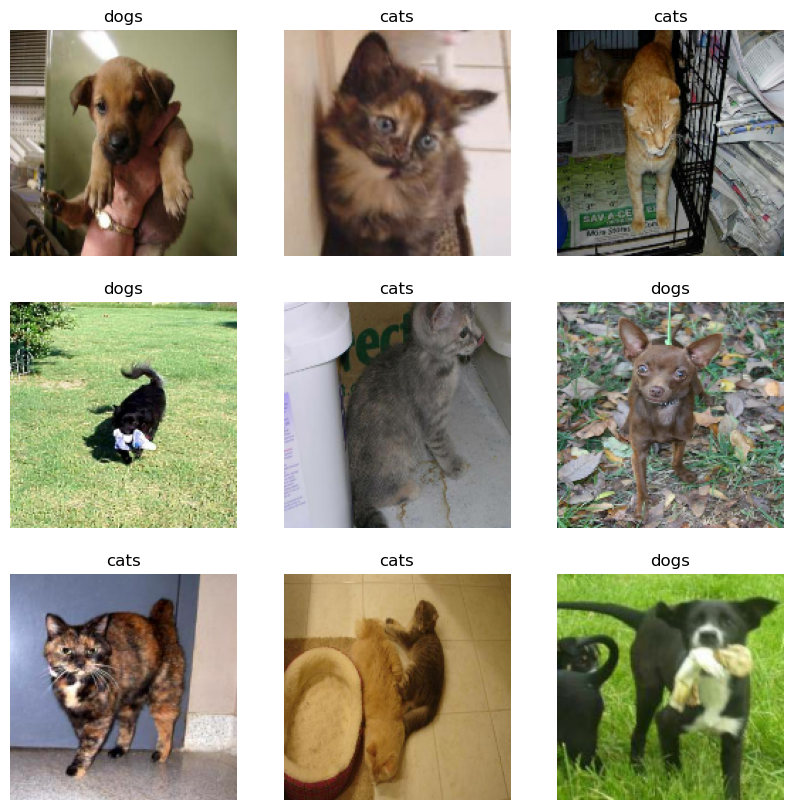

In [9]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

As the Original dataset does not contain a validation set.

In [10]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [11]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 126
Number of test batches: 31


### Configure Dataset for Performance

We will use buffered prefetching to load images from disk. Okay, So I dont know what buffered prefetching is, Wait I`ll explain

What is Buffered Prefetching?

Imagine you’re cooking a meal. While one dish is cooking on the stove, you don’t just stand there waiting. Instead, you might chop vegetables or prepare the next dish. This way, you’re making good use of your time and getting everything ready faster.
Buffered prefetching works in a similar way when a computer is processing data, especially in tasks like training machine learning models. Here’s how it helps:

1. **Getting Ready Ahead of Time**
When a computer is working on one batch of data (like a group of images or numbers), buffered prefetching allows it to prepare the next batch while it’s still working on the current one. This means that the computer doesn’t have to wait around for the next set of data to be ready—it can just keep going.

2. **Keeping Everything Busy**
Just like you don’t want to waste time while cooking, computers also want to stay busy. If one part of the computer (like the CPU) is busy working on data, buffered prefetching ensures that another part (like the GPU, which does heavy lifting for graphics and computations) has the next batch of data ready to go. This overlap keeps everything running smoothly.

3. **Smart Planning**
Buffered prefetching can automatically decide how much data to prepare in advance based on what the computer can handle. It’s like knowing how many ingredients to chop based on how fast your stove cooks.


5. **Faster Cooking**
By preparing data ahead of time and keeping all parts of the computer busy, buffered prefetching helps speed up processes like training a model. This means that tasks that could take a long time can be completed much faster.


In [12]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

## Recaling Images

In a moment, we will download tf.keras.applications.MobileNetV2 for use as your base model. This model expects pixel values in [-1, 1], but at this point, the pixel values in your images vary. To rescale them, use the preprocessing method included with the model.

In [13]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

**Note**: Alternatively, you could rescale pixel values from [0, 255] to [-1, 1] using tf.keras.layers.Rescaling.

In [14]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1) 

## Create the model from pre-trained convnets

We will create the base model from the MobileNet V2 model developed at Google. This is pre-trained on the ImageNet dataset, a large dataset consisting of 1.4M images and 1000 classes. ImageNet is a research training dataset with a wide variety of categories like jackfruit and syringe. This base of knowledge will help us classify cats and dogs from our specific dataset.

First, you need to pick which layer of MobileNet V2 you will use for feature extraction. The very last classification layer (on "top", as most diagrams of machine learning models go from bottom to top) is not very useful. Instead, you will follow the common practice to depend on the very last layer before the flatten operation. This layer is called the "bottleneck layer". The bottleneck layer features retain more generality as compared to the final/top layer.

First, instantiate a MobileNet V2 model pre-loaded with weights trained on ImageNet. By specifying the include_top=False argument, you load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.

In [15]:
IMG_SHAPE = IMG_SIZE + (3,)

base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                         include_top=False,
                                         weights='imagenet')

This feature extractor converts each 160x160x3 image into a 5x5x1280 block of features. Let's see what it does to an example batch of images:

In [16]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


## Feature extraction

Now, we will freeze the convolutional base created from the previous step and to use as a feature extractor. Additionally, you add a classifier on top of it and train the top-level classifier.

### Freeze the convolutional base

It is important to freeze the convolutional base before you compile and train the model. Freezing prevents the weights in a given layer from being updated during training. MobileNet V2 has many layers, so setting the entire model's trainable flag to False will freeze all of them.

If you are like me and wondering why we freeze layers, Here are the Reasons: 

1. **Utilizing Pre trained Features**: MobileNet V2 is often pre-trained on a large dataset like ImageNet. The early layers of the model learn to detect basic features (like edges and textures), which are generally useful for many tasks. By freezing these layers, you can leverage this learned information without altering it.
2. **Reducing Overfitting**: When you have a smaller dataset for your specific task, allowing all layers to be trainable can lead to overfitting, where the model learns noise in the training data rather than generalizable patterns. Freezing some layers helps maintain generalization.
3. **Faster Training**:Training a model with fewer trainable parameters can significantly speed up the training process. This is because fewer weights need to be updated, which reduces computational overhead.
4. **Fine-Tuning**: After initial training with frozen layers, you may choose to unfreeze some of them later on to fine-tune the model. This allows for adjustments based on the specific characteristics of your dataset without starting from scratch.

In [17]:
base_model.trainable = False

### NOTE
Many models contain `tf.keras.layers.BatchNormalization` layers. This layer is a special case and precautions should be taken in the context of fine-tuning, as shown later in this tutorial.

When you set `layer.trainable = False`, the BatchNormalization layer will run in inference mode, and will not update its mean and variance statistics.

When you unfreeze a model that contains BatchNormalization layers in order to do fine-tuning, you should keep the BatchNormalization layers in inference mode by passing `training = False` when calling the base model. Otherwise, the updates applied to the non-trainable weights will destroy what the model has learned.

In [18]:
base_model.summary()

Model: "mobilenetv2_1.00_160"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 80, 80,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 80, 80,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 80, 80,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 80, 80,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 80, 80,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 80, 80,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 81, 81,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 40, 40,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 40, 40,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

## Add a classification head

To generate predictions from the block of features, we will be using `GlobalAveragePooling2D` which allows us to convert a complex set of features from an image into a simpler format—a single vector with 1280 elements—by averaging over spatial locations. This step is crucial for preparing data for subsequent layers in a neural network, such as fully connected layers that make final predictions based on these summarized features.

In [19]:
global_average_layer = GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [20]:
prediction_layer = Dense(1, activation='sigmoid')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


Build a model by chaining together the data augmentation, rescaling, base_model and feature extractor layers using the Keras Functional API. As previously mentioned, use training=False as our model contains a BatchNormalization layer.

In [21]:
inputs = Input(shape=(160, 160, 3))

x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)

outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [22]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [23]:
len(model.trainable_variables)

2

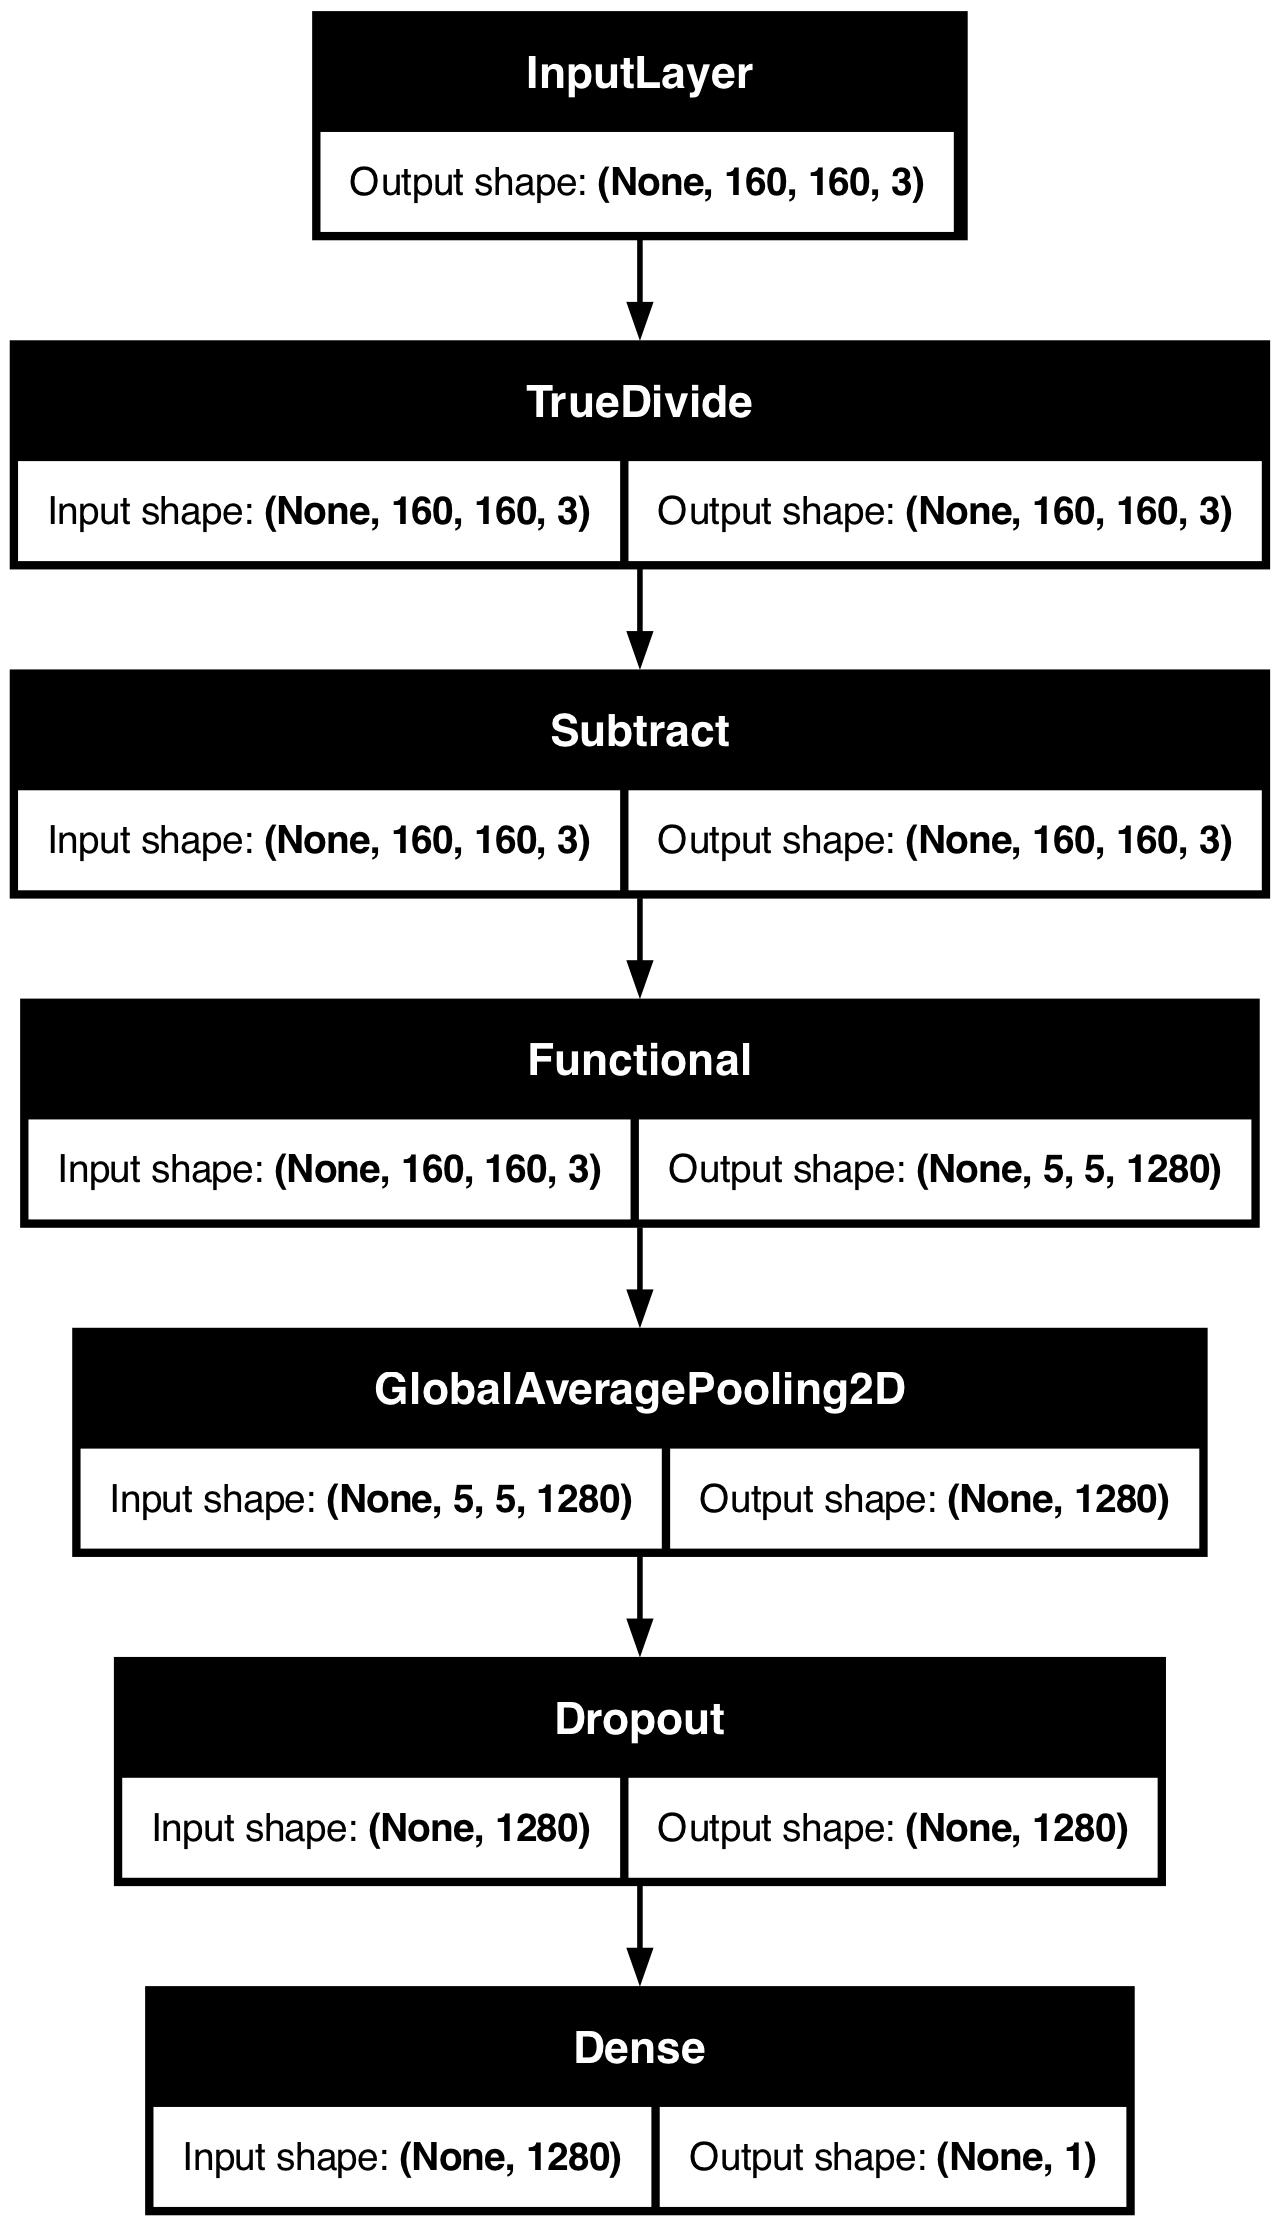

In [25]:
tf.keras.utils.plot_model(model, show_shapes=True)

## Compile Model

In [27]:
base_learning_rate = 0.0001

In [29]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
             loss=tf.keras.losses.BinaryCrossentropy(), 
             metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')])

## Train the Model

In [30]:
epochs = 10

In [32]:
loss0, accuracy0 = model.evaluate(validation_dataset)

126/126 ━━━━━━━━━━━━━━━━━━━━ 12s 88ms/step - accuracy: 0.5644 - loss: 0.7196


In [41]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.73
initial accuracy: 0.56


In [42]:
history = model.fit(train_dataset,
                    epochs=epochs,
                    validation_data=validation_dataset)

Epoch 1/10
626/626 ━━━━━━━━━━━━━━━━━━━━ 78s 120ms/step - accuracy: 0.8125 - loss: 0.4145 - val_accuracy: 0.9671 - val_loss: 0.1154
Epoch 2/10
626/626 ━━━━━━━━━━━━━━━━━━━━ 74s 119ms/step - accuracy: 0.9656 - loss: 0.1111 - val_accuracy: 0.9746 - val_loss: 0.0829
Epoch 3/10
626/626 ━━━━━━━━━━━━━━━━━━━━ 73s 117ms/step - accuracy: 0.9717 - loss: 0.0829 - val_accuracy: 0.9768 - val_loss: 0.0698
Epoch 4/10
626/626 ━━━━━━━━━━━━━━━━━━━━ 74s 117ms/step - accuracy: 0.9775 - loss: 0.0713 - val_accuracy: 0.9783 - val_loss: 0.0620
Epoch 5/10
626/626 ━━━━━━━━━━━━━━━━━━━━ 74s 118ms/step - accuracy: 0.9793 - loss: 0.0612 - val_accuracy: 0.9798 - val_loss: 0.0563
Epoch 6/10
626/626 ━━━━━━━━━━━━━━━━━━━━ 75s 119ms/step - accuracy: 0.9806 - loss: 0.0580 - val_accuracy: 0.9798 - val_loss: 0.0555
Epoch 7/10
626/626 ━━━━━━━━━━━━━━━━━━━━ 77s 122ms/step - accuracy: 0.9815 - loss: 0.0540 - val_accuracy: 0.9813 - val_loss: 0.0538
Epoch 8/10
626/626 ━━━━━━━━━━━━━━━━━━━━ 80s 127ms/step - accuracy: 0.9825 - loss: 0

## Plot Metrics

Text(0.5, 1.0, 'Training and Validation Accuracy')

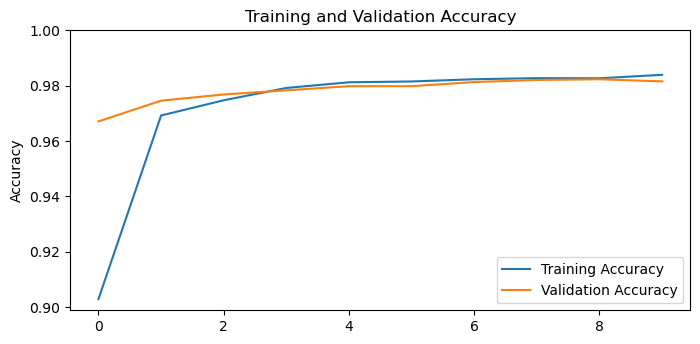

In [45]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

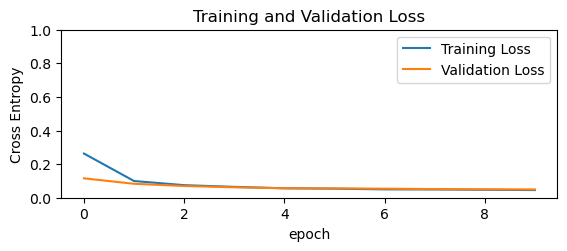

In [44]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

**Note**: If you are wondering why the validation metrics are clearly better than the training metrics, the main factor is because layers like tf.keras.layers.BatchNormalization and tf.keras.layers.Dropout affect accuracy during training. They are turned off when calculating validation loss.

## Fine Tuning

In the feature extraction experiment, you were only training a few layers on top of an MobileNetV2 base model. The weights of the pre-trained network were not updated during training.

One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the classifier you added. The training process will force the weights to be tuned from generic feature maps to features associated specifically with the dataset.

Also, we should try to fine-tune a small number of top layers rather than the whole MobileNet model. In most convolutional networks, the higher up a layer is, the more specialized it is. The first few layers learn very simple and generic features that generalize to almost all types of images. As you go higher up, the features are increasingly more specific to the dataset on which the model was trained. The goal of fine-tuning is to adapt these specialized features to work with the new dataset, rather than overwrite the generic learning.

### Un-Freeze the top layers of the Model

In [46]:
base_model.trainable = True

In [47]:
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  154


In [48]:
# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]: 
    layer.trainable = False

## Compile Model

In [50]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
             optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
             metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')])

In [51]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,862,721 (7.11 MB)

 Non-trainable params: 396,544 (1.51 MB)

In [52]:
len(model.trainable_variables)

56

## Continue training the Model

In [53]:
fine_tune_epochs = epochs + 10

In [54]:
history_fine = model.fit(train_dataset, 
                        epochs=fine_tune_epochs, 
                        initial_epoch=len(history.epoch), 
                        validation_data=validation_dataset)

Epoch 11/20
626/626 ━━━━━━━━━━━━━━━━━━━━ 145s 218ms/step - accuracy: 0.9167 - loss: 0.1961 - val_accuracy: 0.9815 - val_loss: 0.0576
Epoch 12/20
626/626 ━━━━━━━━━━━━━━━━━━━━ 124s 198ms/step - accuracy: 0.9691 - loss: 0.0782 - val_accuracy: 0.9798 - val_loss: 0.0522
Epoch 13/20
626/626 ━━━━━━━━━━━━━━━━━━━━ 137s 219ms/step - accuracy: 0.9750 - loss: 0.0632 - val_accuracy: 0.9785 - val_loss: 0.0604
Epoch 14/20
626/626 ━━━━━━━━━━━━━━━━━━━━ 151s 241ms/step - accuracy: 0.9829 - loss: 0.0481 - val_accuracy: 0.9771 - val_loss: 0.0640
Epoch 15/20
626/626 ━━━━━━━━━━━━━━━━━━━━ 138s 220ms/step - accuracy: 0.9834 - loss: 0.0456 - val_accuracy: 0.9783 - val_loss: 0.0618
Epoch 16/20
626/626 ━━━━━━━━━━━━━━━━━━━━ 143s 228ms/step - accuracy: 0.9873 - loss: 0.0373 - val_accuracy: 0.9768 - val_loss: 0.0658
Epoch 17/20
626/626 ━━━━━━━━━━━━━━━━━━━━ 182s 288ms/step - accuracy: 0.9889 - loss: 0.0322 - val_accuracy: 0.9751 - val_loss: 0.0665
Epoch 18/20
626/626 ━━━━━━━━━━━━━━━━━━━━ 185s 295ms/step - accuracy: 

In [55]:
## Plot Metrics

Text(0.5, 1.0, 'Training and Validation Accuracy')

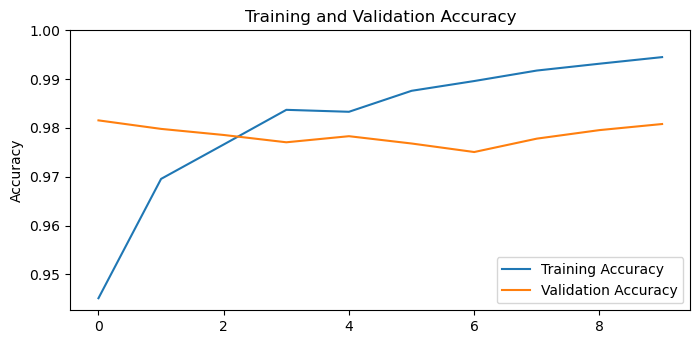

In [57]:
acc = history_fine.history['accuracy']
val_acc = history_fine.history['val_accuracy']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

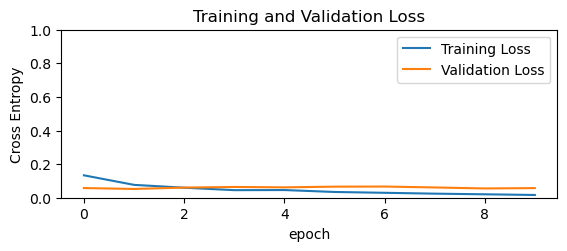

In [58]:
loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Predictions

In [59]:
loss, accuracy = model.evaluate(test_dataset)
accuracy

31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - accuracy: 0.9778 - loss: 0.0604


0.9798387289047241

Predictions:
 [0 1 1 0 0 0 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 0 0 1 1 0 1 1 1 0 1]
Labels:
 [0 1 1 0 0 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 0 1 1 1 0 1]


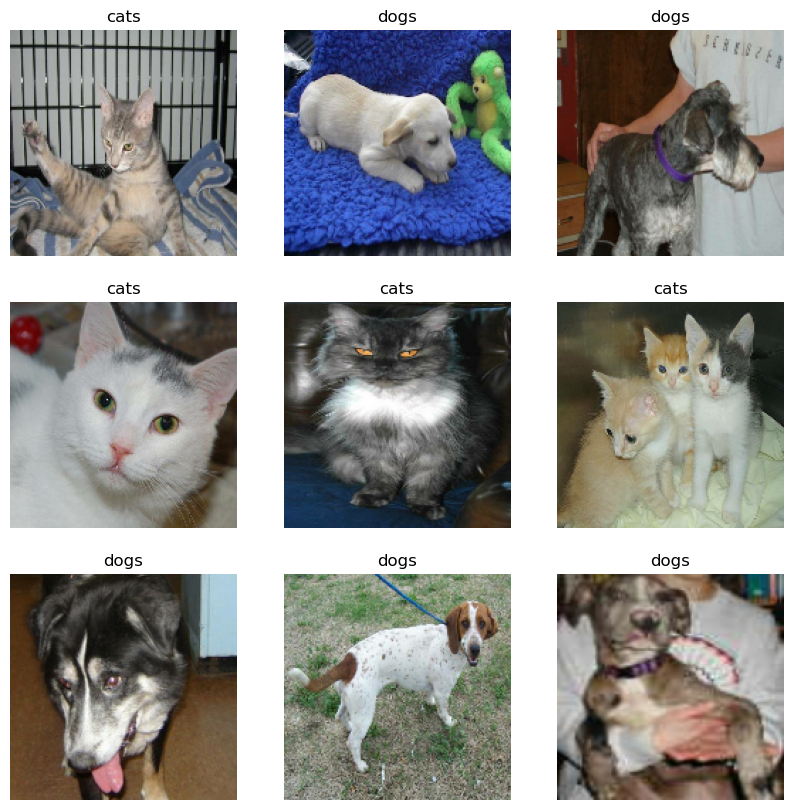

In [61]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")